
MIT Open Source License: <br>
Copyright (c) 2018 Daniel C. Elton 

<sub>Permission is hereby granted, free of charge, to any person obtaining a copy</sub>
<sub>of this software and associated documentation files (the "Software"), to deal</sub>
<sub>in the Software without restriction, including without limitation the rights</sub>
<sub>to use, copy, modify, merge, publish, distribute, sublicense, and/or sell</sub>
<sub>copies of the Software, and to permit persons to whom the Software is</sub>
<sub>furnished to do so, subject to the following conditions:</sub>

<sub>The above copyright notice and this permission notice shall be included in all</sub>
<sub>copies or substantial portions of the Software.</sub>

<sub>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR</sub>
<sub>IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,</sub>
<sub>FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE</sub>
<sub>AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER</sub>
<sub>LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,</sub>
<sub>OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE</sub>
<sub>SOFTWARE.</sub>

### Load all libraries, read in data

In [14]:
%load_ext autoreload
%autoreload 2
from rdkit import Chem
from rdkit.Chem.EState.Fingerprinter import FingerprintMol
from rdkit.Chem import Descriptors
from rdkit.Chem.rdmolops import RDKFingerprint
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import cross_validation
from sklearn import cross_validation
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, Lasso, LinearRegression 
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA, FastICA
from rdkit.Avalon.pyAvalonTools import GetAvalonFP
from sklearn.utils import shuffle
from mmltoolkit.mmltoolkit.featurizations import *

#Read the data
data = pd.read_excel('datasets/Huang_Massa_data_with_all_SMILES.xlsx', skipfooter=1)

target_prop = 'Explosive energy (kj/cc)'

#Add some new columns
data['Mols'] = data['SMILES'].apply(Chem.MolFromSmiles)

#important - add hydrogens!!
data['Mols'] = data['Mols'].apply(Chem.AddHs)

num_mols = len(data)

bond_types, X_LBoB = literal_bag_of_bonds(list(data['Mols'])) 
y = data[target_prop].values

refcodes = list(data['Molecular Name'])

#X_LBoB = shuffle(X_LBoB, random_state=10)
#y = shuffle(y, random_state=10)
#refcodes = shuffle(refcodes, random_state=10)
                                        


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
from sklearn.model_selection import KFold, ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, ShuffleSplit
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from mmltoolkit.mmltoolkit.CV_tools import * 

KR_grid = {"alpha": np.logspace(-9, -5, 10),
           "gamma": np.logspace(-15, -5, 10),  "kernel" : ['rbf']}

model = grid_search(X_LBoB, y, KernelRidge(), param_grid=KR_grid, verbose = True, cv=KFold(n_splits=30,shuffle=False))

best params:
{'kernel': 'rbf', 'gamma': 4.6415888336127918e-09, 'alpha': 1.6681005372000591e-07}
neg_mean_absolute_error:
0.366813516925


# Leave-one-out CV analysis of residuals

In [16]:
X_LBoB[0]

array([  0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   7.,  12.,
         0.,   7.,   0.,   0.,   7.,   0.,   0.,   0.,   0.])

In [17]:
import matplotlib.pyplot as plt 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold, ShuffleSplit
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)

x = X_LBoB

kf = KFold(n_splits=num_mols, shuffle=False)

residuals = []
all_y_pred = []
for k, (train, test) in enumerate(kf.split(x,y)):
    model.fit(x[train], y[train])
    y_test = y[test]
    y_pred = model.predict(x[test])
    all_y_pred += [y_pred]
    residuals += [y_pred - y_test]

residuals = np.array(residuals)
all_y_pred = np.array(all_y_pred)

scores = abs(residuals)
MAE = np.mean(scores)
print(MAE)

scores_df = data
scores_df['y_pred'] = all_y_pred.reshape(-1,1)
scores_df['residual (y_pred - y_test)'] = residuals.reshape(-1,1)
scores_df['score'] =  scores.reshape(-1,1)
scores_df['Explosive energy (kj/cc)'] = scores_df['Explosive energy (kj/cc)'].astype('float')

0.367917746988


In [18]:
scores_df = scores_df.sort_values(by=['score'], ascending=False)

In [19]:
scores_df.head()

,num,Molecular Name,Formula,Density (g/cm3),Delta Hf solid (kj/mol),Explosive energy (kj/cc),Shock velocity (km/s),Particle velocity (km/s),Speed of sound (km/s),Pressure (Gpa),T(K),TNT Equiv (per cc),group,SMILES,NOTE,Mols,y_pred,residual (y_pred - y_test),score
0,1,CUGCOW,C8N7O14H1,2.024,641.16,6.419,9.569,2.519,7.050,48.777,5440,2.233,Cubane,O=N(=O)C12C3C4(N(=O)=O)C1(N(=O)=O)C1(N(=O)=O)C...,NaN,<rdkit.Chem.rdchem.Mol object at 0x109ee4080>,4.835063,-1.583937,1.583937
53,54,QQQBRD02,C2N6O12,2.075,98.59,4.046,8.246,1.975,6.272,33.789,2073,0.864,Linear,O=N(=O)C(N(=O)=O)(N(=O)=O)C(N(=O)=O)(N(=O)=O)N...,NaN,<rdkit.Chem.rdchem.Mol object at 0x11c3963a0>,5.406259,1.360259,1.360259
98,108,CUBANE,C8H8,1.288,584.67,0.954,6.700,1.217,5.483,10.501,2446,1.007,Cubane,C12C3C4C1C1C2C3C41,NaN,<rdkit.Chem.rdchem.Mol object at 0x11c1a63f0>,2.239615,1.285615,1.285615
55,56,CEYDUF,C5N8O16H4,1.940,-23.34,3.960,8.805,2.021,6.784,34.514,3893,1.577,Linear,O=N(=O)C(CC(N(=O)=O)(N(=O)=O)N(=O)=O)(CC(N(=O)...,NaN,<rdkit.Chem.rdchem.Mol object at 0x11c3968f0>,5.052382,1.092382,1.092382
96,106,TAHMEV,C8N1O2H7,1.474,530.34,1.640,6.686,1.492,5.194,14.699,3166,1.112,Cubane,O=N(=O)C12C3C4C5C3C1C5C24,NaN,<rdkit.Chem.rdchem.Mol object at 0x11c1a6300>,2.579762,0.939762,0.939762


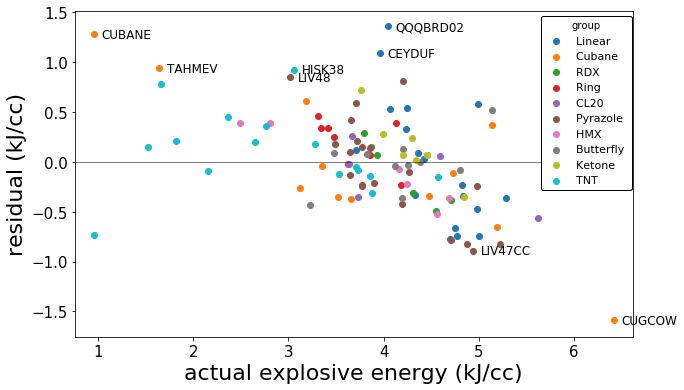

In [20]:
fig = plt.figure(figsize=(10,6))
pltx = list(scores_df[target_prop].values)
plty = list(scores_df['residual (y_pred - y_test)'].values)

plt.clf()


groups = set(scores_df['group'].values)

ax = plt.gca()
outliers = []

for group in groups: 
    mask = list(scores_df['group']==group)
    scores_group = scores_df[mask]
    molx = list(scores_group[target_prop].values)
    moly = list(scores_group['residual (y_pred - y_test)'].values)
    plt.scatter(molx, moly, label=group)
    #for (i, residual) in enumerate(moly):
    #    if (abs(residual) > 0.9):
    #        refcode = scores_group['refcode'].iloc[i]
    ##        ax.annotate(refcode, (molx[i] + 0.08 , moly[i] - 0.04),  fontsize=12 )
    #        outliers += [refcode]

for (i, residual) in enumerate(plty):
    if (abs(residual) > 0.85):
        ax.annotate(scores_df['Molecular Name'].iloc[i], (pltx[i] + 0.08 , plty[i] - 0.04),  fontsize=12 )
        outliers += [i]

minx = min(pltx) - 0.2
maxx = max(pltx) + 0.2
plt.plot([minx,maxx],[0,0],'k-',linewidth=.5)
plt.xlim([minx,maxx])
plt.ylabel('residual (kJ/cc)',fontsize=22)
plt.xlabel('actual explosive energy (kJ/cc)', fontsize=22)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
plt.legend(fontsize=11, title= 'group', edgecolor='k', loc=(.835,.45), framealpha=1)
plt.savefig('HM_LBoB_EE_residuals.eps')
plt.show()

# group based residual 

In [21]:
from mmltoolkit.mmltoolkit.CV_tools import r2Pearson, R2
group_avg_residual = {}
group_abs_err = {}
group_num = {}
group_r2 = {}
group_R2 = {}


for group in groups: 
    group_df = scores_df[scores_df['group'] == group]
    group_avg_residual[group] = group_df['residual (y_pred - y_test)'].mean()
    group_abs_err[group] = np.abs(group_df['residual (y_pred - y_test)']).mean()
    group_num[group] = len(group_df)
    group_r2[group] = r2Pearson(group_df['Explosive energy (kj/cc)'].values, group_df['y_pred'].values)
    group_R2[group] = R2(group_df['Explosive energy (kj/cc)'].values, group_df['y_pred'].values)

    sorted_groups = sorted(group_avg_residual, key=group_r2.__getitem__, reverse=True)

print("\\begin{tabular}{c c c c c c}") 
print("     group   & N_{\\ff{group}} & $r$ & R$^2$ & MAE  & avg.\\ residual (kJ/cc) \\\\ ")
print("\\hline")
for i in range(len(sorted_groups)):
    group = sorted_groups[i]
    print("%30s & %3i & %6.3f & %6.2f  & %6.2f & %6.2f   \\\\" % (group, group_num[group], group_r2[group], group_R2[group], group_abs_err[group],  group_avg_residual[group]) ) 
print("\\end{tabular}") 


\begin{tabular}{c c c c c c}
     group   & N_{\ff{group}} & $r$ & R$^2$ & MAE  & avg.\ residual (kJ/cc) \\ 
\hline
                          HMX  &   6 &  0.968 &   0.83  &   0.32 &  -0.06   \\
                    Butterfly  &  10 &  0.917 &   0.78  &   0.18 &  -0.01   \\
                          TNT  &  16 &  0.854 &   0.83  &   0.31 &   0.10   \\
                         CL20  &   6 &  0.854 &   0.83  &   0.22 &  -0.09   \\
                       Cubane  &  12 &  0.814 &   0.75  &   0.58 &  -0.04   \\
                         Ring  &   8 &  0.548 &   0.17  &   0.26 &   0.20   \\
                          RDX  &   6 &  0.377 &   0.19  &   0.28 &  -0.11   \\
                     Pyrazole  &  20 &  0.254 &   0.21  &   0.42 &  -0.07   \\
                       Ketone  &   7 &  0.099 &  -0.13  &   0.25 &   0.15   \\
                       Linear  &  18 &  0.003 &  -1.12  &   0.52 &   0.00   \\
\end{tabular}


# 3D plotting

In [23]:
import py3Dmol


worst_performing = [scores_df.iloc[i]['Molecular Name'] for i in outliers]
scores  = [scores_df.iloc[i]['score'] for i in outliers]

num = len(worst_performing)
num_cols = 2

view = py3Dmol.view(linked=False,viewergrid=(2, 5),width=10000,height=2050)
view.setViewStyle({'style':'outline','color':'None','width':0.0010})
view.removeAllModels(viewer=(0,0))


for (i, refcode) in enumerate(worst_performing):
    file_HM = open('HM_all_xyz_files/'+refcode+'.xyz', 'r')
    xyz_HM = file_HM.read()
   
    if (i < 5):
        view.addModel(xyz_HM,'mol',viewer=(0, i))
        view.setStyle({'stick':{}},viewer=(0, i))
        view.zoomTo(viewer=(0, i))
    if (i >= 5):
        view.addModel(xyz_HM,'mol',viewer=(1, i-5))
        view.setStyle({'stick':{}},viewer=(1, i-5))
        view.zoomTo(viewer=(1, i-5))

view.render()


ImportError: No module named 'py3Dmol'

In [65]:
for mol in worst_performing[0:5]:
    print(mol+"                         ", end='')

CUGCOW                         QQQBRD02                         CUBANE                         CEYDUF                         TAHMEV                         